<a href="https://colab.research.google.com/github/ZackAkil/deep-tic-tac-toe/blob/master/%5Bplayer_goes_first%5D_deep_learning_tic_tac_toe_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt


In [0]:
#@title
# rewards
WIN = 1
LOSE = -2
TIE = 0.2
INVALID = -3


class XandOs():
  def __init__(self, log = False):
    self.state = np.zeros([3,3], dtype=np.int16)
    self.end = False
    self.history = []
    self.log = log

  def make_move(self, pos, player=1):
  
    if self.state.flatten()[pos]:
      # invalid move
      if self.log:
        print('player {0} INVALID move {1}'.format(player, pos))
      return False
    else:
      # make move
      if self.log:
        print('player {0} making move {1}'.format(player, pos))
      grid = self.state.flatten()
      grid[pos] = player
      self.state = np.reshape(grid, [3,3])
      return True

  def check_win(self, player=1):
    bool_grid = self.state == player
    return win(bool_grid)


  def step(self, action):

    self.history.append([self.state, action])
    reward = 0
    pos = action
    valid_move = self.make_move(pos, player=1)

    if not valid_move:
      reward = INVALID
      self.end = True

    elif self.check_win(player=1):
      if self.log:
        print('player 1 win')
      reward = WIN
      self.end = True

    elif self.game_full():
      if self.log:
        print('player 1 ended game')
      self.end = True
      reward = TIE

    if self.end:  
      return reward, self.state, self.end

    # player 2 move
    player_2_move = self.rand_agent_move(player=2)
    valid_move = self.make_move(player_2_move, player=2)

    if not valid_move:
      reward = WIN
      self.end = True

    elif self.check_win(player=2):
      if self.log:
        print('player 2 win')
      reward = LOSE
      self.end = True

    elif self.game_full():
      if self.log:
        print('player 2 ended game')
      self.end = True
      reward = TIE

    return reward, self.state, self.end



  def render(self):
    render_game(self.state)

  def game_full(self):
    return (self.state==0).sum() == 0


  def rand_agent_move(self, player = 2):

    flat_state = self.state.flatten() == 0
    empty_indexs, = np.where(flat_state)

    for indx in empty_indexs:
      grid = self.state.flatten() == player
      grid[indx] = True
      if win(np.reshape(grid,[3,3])):
        if self.log:
          print('found winning move ')
        return indx
    if len(empty_indexs):
      return np.random.choice(empty_indexs)
    else:
      return 0

def win(bool_grid):
  # horizontal
  for row in bool_grid:
    if row.sum() == 3:
      return True

  # vertical
  for row in bool_grid.T:
    if row.sum() == 3:
      return True

  # diangonal 1
  if np.reshape(bool_grid,[-1])[::4].sum() == 3:
    return True

  # diangonal 2
  if np.reshape(bool_grid,[-1])[2:7:2].sum() == 3:
    return True

  return False

def render_game(state):

    # data = np.reshape(pred, [3,3])
    fig, ax = plt.subplots()
    im = ax.imshow(state/2, cmap=plt.get_cmap('cool'), interpolation='nearest',
              vmin=0, vmax=1)
    text_num = 0
    for i in range(3):
      for j in range(3):
        ax.text(j, i, str(text_num))
        text_num += 1

      # Minor ticks
    fig.colorbar(im)
    plt.show()

In [0]:
game = XandOs()

(0, array([[0, 1, 0],
       [0, 0, 0],
       [2, 0, 0]], dtype=int16), False)


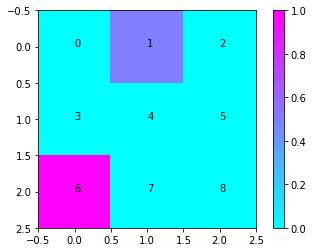

In [0]:
print(game.step(1))
game.render()

(0, array([[0, 0, 0],
       [1, 0, 0],
       [0, 2, 0]], dtype=int16), False)


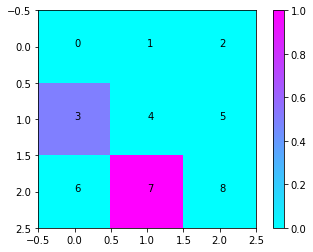

(0, array([[0, 0, 1],
       [1, 2, 0],
       [0, 2, 0]], dtype=int16), False)


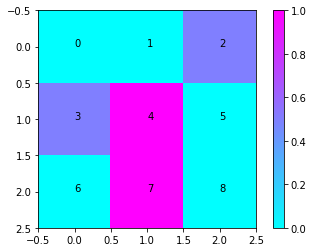

(-3, array([[0, 0, 1],
       [1, 2, 0],
       [0, 2, 0]], dtype=int16), True)


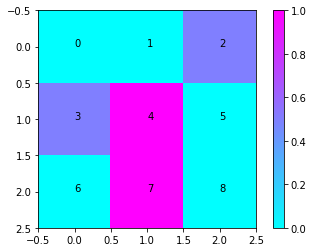

In [0]:
game = XandOs()

while(not game.end):
  move = np.random.choice(range(9))
  print(game.step(move))
  game.render()



In [0]:
len(game.history)

3

In [0]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose
from keras import backend as K

Using TensorFlow backend.


In [0]:
from collections import deque

In [0]:
class Agent():

  def __init__(self):
    self.model = self.create_model()

  def create_model(self):
    model = Sequential()
    # model.add(Flatten(input_shape=[3,3,2]))
    model.add(Conv2D(8, kernel_size=(1, 1),
                 activation='relu',
                 input_shape=[3,3,2],
                 strides=(1,1), padding='same'))
    model.add(Conv2D(8, (3, 3), activation='relu',padding='same'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(9, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

  def show_heat_map(self, pred):
    data = np.reshape(pred, [3,3])
    fig, ax = plt.subplots()
    im = ax.imshow(data, cmap=plt.get_cmap('hot'), interpolation='nearest',
              vmin=0, vmax=1)
    fig.colorbar(im)
    plt.show()

  def decide_move(self, env, show=True, only_valid=False):
    model_input = np.zeros([1,3,3,2])
    model_input[0,:,:,0] = env==1
    model_input[0,:,:,1] = env==2
    
    pred = np.squeeze(self.model.predict(model_input))
    # print(pred.shape, (env != 0).flatten().shape)
    if only_valid:
      pred[(env != 0).flatten()] = 0
    
    if show:
      self.show_heat_map(pred)
    return pred.argmax(), pred


# The game

In [0]:
from sklearn.preprocessing import normalize

In [0]:
def render_all(things,vmin=0, vmax=2, cmap='cool', show_max=True):
  display_all = np.zeros([3,3*(len(things))])
  for i, thing in enumerate(things):
    if show_max:
      print('make move: ', thing.argmax())
    step = 3*i
    display_all[:,step:step+3] = np.reshape(thing, [3,3])
  plt.imshow(display_all, vmin=vmin, vmax=vmax, cmap=cmap)
  plt.show()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


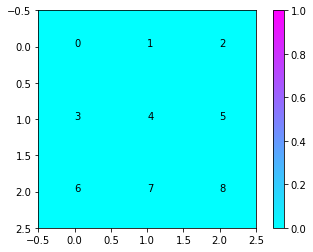

In [0]:
game = XandOs()
agent = Agent()
game.render()

In [0]:
!wget https://github.com/ZackAkil/deep-tic-tac-toe/raw/master/python%20model%20weights/winer_weights.keras 


--2020-02-03 23:48:48--  https://github.com/ZackAkil/deep-tic-tac-toe/raw/master/python%20model%20weights/winer_weights.keras
Resolving github.com (github.com)... 192.30.253.113
Connecting to github.com (github.com)|192.30.253.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ZackAkil/deep-tic-tac-toe/master/python%20model%20weights/winer_weights.keras [following]
--2020-02-03 23:48:48--  https://raw.githubusercontent.com/ZackAkil/deep-tic-tac-toe/master/python%20model%20weights/winer_weights.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39168 (38K) [application/octet-stream]
Saving to: ‘winer_weights.keras.1’

winer_weights.keras 100%[===================>]  38.25K  --.-KB/s    in 0.01s   

In [0]:
agent.model.load_weights('winer_weights.keras')

ValueError: ignored

In [0]:
agent.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 3, 3, 8)           24        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 8)           584       
_________________________________________________________________
flatten_1 (Flatten)          (None, 72)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               7300      
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)              

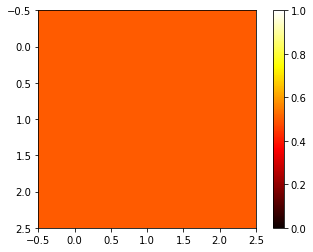

In [0]:
move, pred = agent.decide_move(game.state , only_valid=True)

In [0]:
from copy import deepcopy

def apply_rewards(reward, predictions, decay = 0.5):
  # copy and reverse (more reward applied to latest moves)
  output = deepcopy(predictions)[::-1]
  applied_reward = reward
  for pred, move in output:
    move_index =  np.unravel_index(move, pred.shape)
    pred[ move_index ] = np.clip(pred[ move_index ] + applied_reward, 0, 1)
    applied_reward *= decay
  # un-reverse 
  return [o[0] for o in output[::-1]]

In [0]:
def get_states(memory):
  return [m[0] for m in memory]

def get_new_qs(memory):
  return [m[1] for m in memory]

def render_memory(memory):
  states = get_states(memory)
  updated = get_new_qs(memory)
  current = [m[2][0] for m in memory]
  print('states')
  render_all(states)
  print('current qs')
  render_all(current)
  print('upated qs')
  render_all(updated)


In [0]:
def agent_perf(agent, n= 100,lose_score = LOSE, show_lose=False):
  game_scores = []
  for i in range(n):
    # play game
    game = XandOs()
    while not game.end:
      move, pred = agent.decide_move(game.state, False)
      predictions.append(pred)
      _reward, _state, _end = game.step(move)
    if show_lose:
      if(_reward == lose_score):
        render_all(np.array([h[0] for h in game.history] ) )
    game_scores.append(_reward)
  return np.mean(game_scores), game_scores

In [0]:
memory = []
EPSILON = 0.01

for i in range(1_000):

  # print('NEW GAME')
  game = XandOs()
  predictions = []
  # randomly who starts
  if np.random.random() > 0.5:
    game.make_move(game.rand_agent_move(), player=2) 
    # print('player 2 first')  
  
  while not game.end:
    # game.render()
    move, pred = agent.decide_move(game.state, False, only_valid=True)
    if np.random.random() < EPSILON :
      move = game.rand_agent_move(player = 1)
    predictions.append([pred, move])
    _reward, _state, _end = game.step(move)
  # print(_reward)

  if _reward == INVALID:
    # invalid move reward
    # strongly punish last move
    updated_q = apply_rewards(_reward, predictions, decay=0)
  else:
    # valid move reward
    # normally reward previous moves
    updated_q = apply_rewards(_reward, predictions, decay=0.9)

  states = [h[0] for h in game.history]
  for j in range(len(updated_q)):
    memory.append( [states[j], updated_q[j], predictions[j]])


states
make move:  1
make move:  1
make move:  1
make move:  0
make move:  0
make move:  0
make move:  5
make move:  5
make move:  5
make move:  1


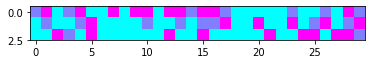

current qs
make move:  6
make move:  3
make move:  4
make move:  2
make move:  3
make move:  7
make move:  2
make move:  4
make move:  8
make move:  0


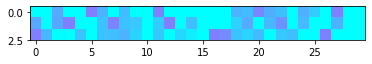

upated qs
make move:  6
make move:  3
make move:  4
make move:  2
make move:  3
make move:  7
make move:  2
make move:  4
make move:  8
make move:  0


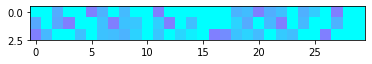

In [0]:
render_memory(memory[-10:])

In [0]:
moves = [p[2][0] for p in memory]
moves_np = np.squeeze(np.array(moves).sum(axis=1))
moves_np.shape

(3266,)

In [0]:
_X = np.array(get_states(memory))
X = np.zeros([*_X.shape,2])
X[:,:,:,0] = (_X == 1)
X[:,:,:,1] = (_X == 2)
y = np.squeeze(np.array(get_new_qs(memory)))

y_sum = y.sum(axis=1)

pos = (y_sum > moves_np)

positive_rewards = pos.sum()
negative_rewards = (~pos).sum()
print('{} positive change, {} negative change'.format(positive_rewards ,negative_rewards))
updated_moves = y.argmax(axis=1)
updated_moves

moves = [p[2][1] for p in memory]
mask = (moves_np != updated_moves)

X = X[mask]
y = y[mask]



2834 positive change, 432 negative change


In [0]:
moves_np

array([4.716607 , 1.8522296, 2.5783396, ..., 3.4604878, 2.5777278,
       1.6078216], dtype=float32)

In [0]:
moves_np != updated_moves

array([ True,  True,  True, ...,  True,  True,  True])

In [0]:
pos_weight =  negative_rewards/len(y)
neg_weight =  positive_rewards/len(y)

weights = np.zeros(len(y))
weights[pos] = pos_weight
weights[~pos] = neg_weight
pos_weight,neg_weight



(0.13227189222290264, 0.8677281077770974)

In [0]:
mask.sum()

3266

In [0]:
X.shape, y.shape

((3266, 3, 3, 2), (3266, 9))

In [0]:
# mean, scores = agent_perf(agent,n=1000)
# mean

In [0]:

hist = agent.model.fit(X, y, epochs=150, verbose=1, batch_size=124) # , sample_weight=weights)

Epoch 1/150
3266/3266 [==============================] - 0s 71us/step - loss: 0.3687
Epoch 2/150
3266/3266 [==============================] - 0s 46us/step - loss: 0.3676
Epoch 3/150
3266/3266 [==============================] - 0s 48us/step - loss: 0.3668
Epoch 4/150
3266/3266 [==============================] - 0s 42us/step - loss: 0.3663
Epoch 5/150
3266/3266 [==============================] - 0s 45us/step - loss: 0.3661
Epoch 6/150
3266/3266 [==============================] - 0s 46us/step - loss: 0.3662
Epoch 7/150
3266/3266 [==============================] - 0s 45us/step - loss: 0.3656
Epoch 8/150
3266/3266 [==============================] - 0s 44us/step - loss: 0.3659
Epoch 9/150
3266/3266 [==============================] - 0s 42us/step - loss: 0.3659
Epoch 10/150
3266/3266 [==============================] - 0s 45us/step - loss: 0.3656
Epoch 11/150
3266/3266 [==============================] - 0s 44us/step - loss: 0.3656
Epoch 12/150
3266/3266 [==============================] - 0s 44

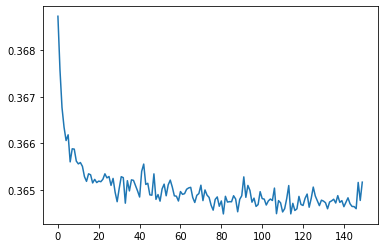

In [0]:
plt.plot(hist.history['loss'])

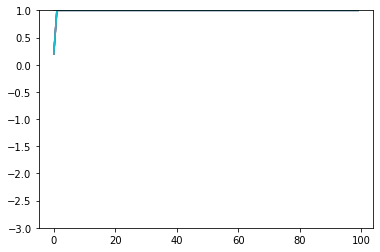

1.0

In [0]:
means = []
for i in range(10):
  mean, scores = agent_perf(agent,n=100,show_lose=True)
  means.append(mean)
  plt.plot(sorted(scores))
plt.ylim(INVALID,WIN)
plt.show()
max(means)


In [0]:
mean, scores = agent_perf(agent,n=100, show_lose=True)
mean

1.0

# Lets play

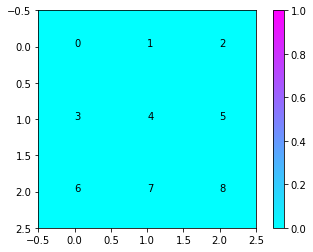

3


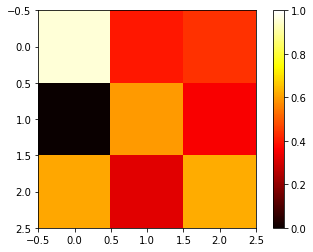

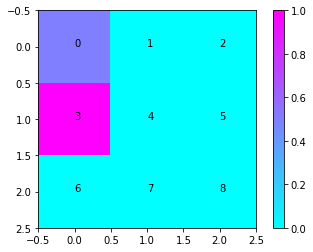

valid move True
[9.5911449e-01 4.0012732e-01 4.3898532e-01 3.2782555e-07 5.9564728e-01
 3.5727382e-01 6.1504680e-01 3.2291222e-01 6.2474960e-01]
4
4 True


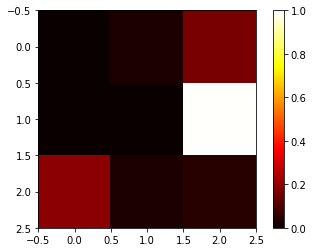

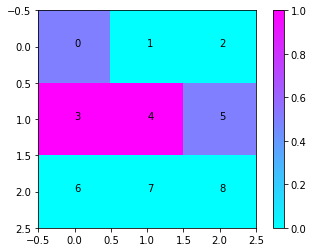

valid move True
[0.         0.02969357 0.16465813 0.         0.         0.9955013
 0.19414705 0.02345785 0.04613736]
6
6 True


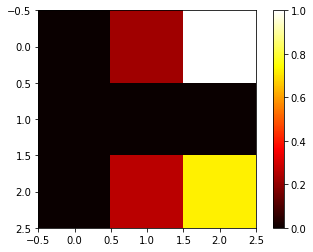

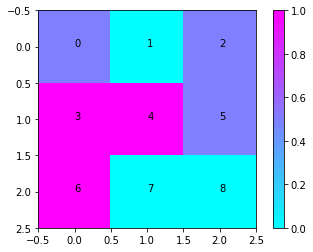

valid move True
[0.0000000e+00 2.2417915e-01 9.9990451e-01 0.0000000e+00 0.0000000e+00
 2.9802322e-08 0.0000000e+00 2.6210201e-01 7.2412694e-01]


KeyboardInterrupt: ignored

In [0]:
game = XandOs()

game.render()
player_move = int(input())
player_reward = game.make_move(player_move, player=2)

while not game.end:
  move, pred = agent.decide_move(game.state)
  reward = game.make_move(move)
  game.render()
  print('valid move', reward)
  print(pred)

  if not game.end:
    player_move = int(input())
    player_reward = game.make_move(player_move, player=2)
    print(player_move, player_reward)



In [0]:
|game.end

False

In [0]:
game.end

In [0]:
agent.model.save('v4.keras')

In [0]:
agent.model.save_weights('winer_weights_v3.keras')